Name: Nathan Dang

Applied Machine Learning - DSCI225

Instructor: Prof. Basye

Date: 04/18/2020

# Lab 7 - Style transfer with CNNs

### Prompt:

Visit and read the tutorial at https://www.tensorflow.org/tutorials/generative/style_transfer.

Build a new notebook for this lab. Much of the contents will probably be cut-and-paste from the tutorial - that's OK. If you borrow chunks from anywhere other than the book's notebooks, be sure to document that with a link to where the code came from.
Find your own images to work with, both in terms of style and content. What happens if you use the same image for both?
The tutorial uses a very abstract style image and a very realistic content image. What happens if we reverse this? E.g. try using a very realistic style image and a cartoon for the content.

The remainder of the lab is up to you, try some other things, work to understand the more confusing parts of the tutorial - read through it and see what parts don't make much sense. Possible confusing items: einsum, GradientTape, frequency in images.
In addition, you should also keep progress notes, which will become part of your submission. At the bottom of your notebook, make a single text cell for these notes. Your notes should include two kinds of entries: experiments and investigations.

Experiment entries should read like this: "I (or We) wondered what would happen if we did <thing>. So we I/We tried this by <describe experiment>. and the result was <result>." Investigation entries should read like this: "I/We didn't understand <something>. We found an explanation at <link> (or perhaps, we talked to <person>) and now I/We understand it."
You may add other kinds of progress entries as you see fit, e.g. "I figured out a clever way to do <something>." But you should have at least 5 experiment and 5 investigation entries.
    
<b>NOTE:</b> I marked checkpoints throughout our process which can be seen by the label of a progress log (i.e. "Progress Log 1," "Progress Log 2," etc) followed by a summary of what was going on on each checkpoint. The full documentation of the log can be found at the end of the notebook. 

## Setup

In [1]:
import tensorflow as tf

import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [2]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

Define a function to load an image and limit its maximum dimension to 512 pixels.

In [3]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

Create a simple function to display an image.

In [4]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

## Getting the data images

### Progress Log 1

Define the path to get the data. In this case, inside the folder containing the notebook, there is a folder named "data" which contains 2 images, content.jpg (a picture of two pigeons in Paris) and style.jpg (the Starry Night painting by Vincent Van Gogh). 

In [5]:
content_path = 'data/content.jpg'
style_path = 'data/style.jpg'

Visualise the input images.

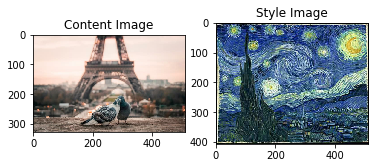

In [6]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

## Fast Style Transfer using TF-Hub

### Progress Log 2

In this step, I used Fast Style Transfer from TF-Hub on three cases: regular case, same image for both, and swapping the images, and made some comparision with these results with the ones obtained when I actually built the model.

Regular case, use the definded images as they are.

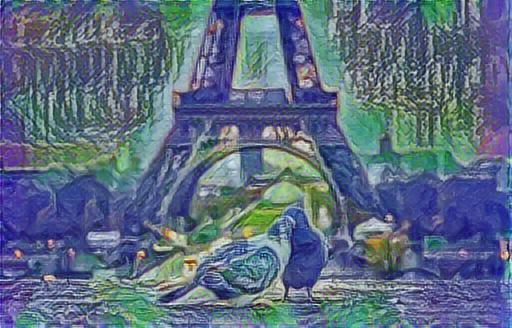

In [7]:
import tensorflow_hub as hub
hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/1')
stylized_image = hub_module(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

Use the same image for both content and style.

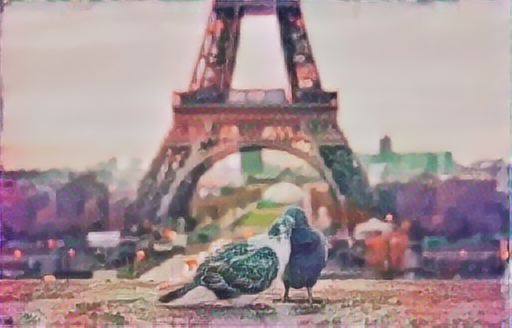

In [8]:
content_image = load_img(content_path)
style_image = load_img(content_path)
stylized_image = hub_module(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

Swap the images for content and style.

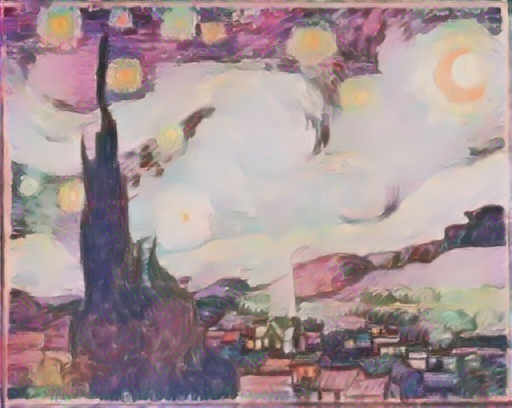

In [9]:
content_image = load_img(style_path)
style_image = load_img(content_path)
stylized_image = hub_module(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

<b>Observation:</b> the Fast Style Transfer from TF-hub does not do a very good job. Specifically, looking at the result of the first case, the style embedded in the picture did not look like Van Gogh's style in the Starry Night, for me it's not even half-way close. For the second case, the realistic picture now looks more cartoon-like and for the third case, the Starry Night painting is coverred with the colours of the realistic image.

### Progress Log 3

At this point, I tried to build the exact same model from the tutorial and have it run on my images and then compare the results with the ones obtained from Fast Style Transfer above. Later on, I tried adding some bells and whistles such as having different layers for content/style to see what would happen. During the process, I did soem research on einsum() to have a better understading about what was going on.

## Define content and style representations

Load a VGG19 and test run it on our image to ensure it's used correctly:

In [10]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [11]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[('book_jacket', 0.2576487),
 ('comic_book', 0.11188905),
 ('prayer_rug', 0.11116676),
 ('jigsaw_puzzle', 0.07259453),
 ('wardrobe', 0.05264323)]

In [12]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)


input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [13]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

Reload the original data images.

In [14]:
content_image = load_img(content_path)
style_image = load_img(style_path)

## Build the model

This following function builds a VGG19 model that returns a list of intermediate layer outputs.

In [15]:
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

And to create the model.

In [16]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 407, 512, 64)
  min:  0.0
  max:  813.9832
  mean:  30.523067

block2_conv1
  shape:  (1, 203, 256, 128)
  min:  0.0
  max:  5105.642
  mean:  200.21123

block3_conv1
  shape:  (1, 101, 128, 256)
  min:  0.0
  max:  6496.55
  mean:  185.24466

block4_conv1
  shape:  (1, 50, 64, 512)
  min:  0.0
  max:  20722.121
  mean:  639.41943

block5_conv1
  shape:  (1, 25, 32, 512)
  min:  0.0
  max:  4153.514
  mean:  52.80237



## Calculate style

Style calculation is implemented concisely using the tf.linalg.einsum function. For more details, refer to the tutorial link which is attached at the beginning of the notebook.

In [17]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

## Extract style and content

Build a model that returns the style and content tensors.

In [18]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}

When called on an image, this model returns the gram matrix (style) of the style_layers and content of the content_layers:

In [19]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

style_results = results['style']

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
print()

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.015391409
    max:  64293.316
    mean:  310.50476

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  81377.35
    mean:  10615.193

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  253920.17
    mean:  9563.589

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  2516687.0
    mean:  134336.42

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  67095.27
    mean:  1183.6329

Contents:
   block5_conv2
    shape:  (1, 20, 32, 512)
    min:  0.0
    max:  1044.2454
    mean:  11.9255



## Run gradient descent

With this style and content extractor, we can now implement the style transfer algorithm. Do this by calculating the mean square error for your image's output relative to each target, then take the weighted sum of these losses.

Set the style and content target values:

In [20]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

Define a tf.Variable to contain the image to optimize.

In [21]:
image = tf.Variable(content_image)

Since this is a float image, define a function to keep the pixel values between 0 and 1:

In [22]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

Create an optimizer. The paper recommends LBFGS, but Adam works okay, too:

In [23]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

To optimize this, use a weighted combination of the two losses to get the total loss:

In [24]:
style_weight=1e-2
content_weight=1e4

In [25]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

Use tf.GradientTape to update the image.

In [26]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

Now run a few steps to test:

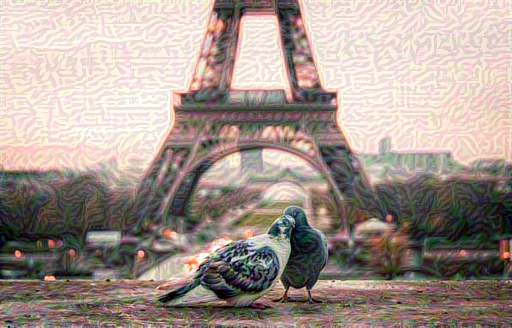

In [27]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

Since it's working, perform a longer optimization:

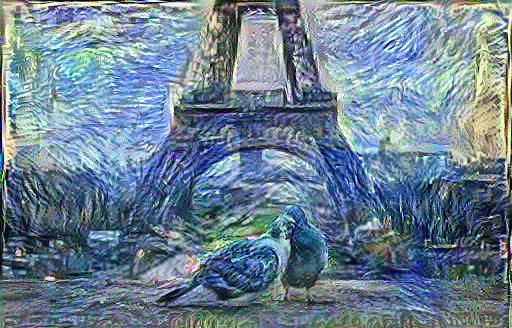

Train step: 1000
Total time: 2507.8


In [28]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))
  
end = time.time()
print("Total time: {:.1f}".format(end-start))

<b>Observation:</b> this picture looks better than the one given by TF-hub Fast Style Transfer. Specifically, it does a much better job on capturing Van Gogh's style.

## Total variation loss

Calculate the total variation loss.

In [29]:
tf.image.total_variation(image).numpy()

array([117810.266], dtype=float32)

## Re-run the optimization

Choose a weight for the total_variation_loss:

In [30]:
total_variation_weight=30

Include it in the train_step function:

In [31]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

Reinitialize the optimization variable:

In [32]:
image = tf.Variable(content_image)

Run the optimization:

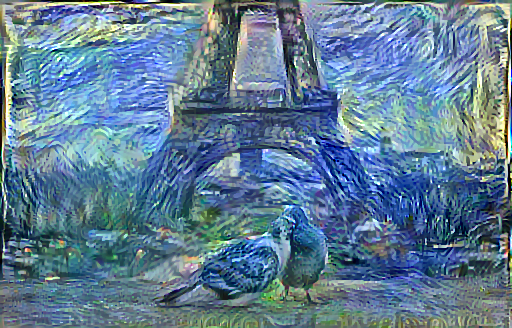

Train step: 1000
Total time: 2503.1


In [33]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

<b>Observation:</b> this picture looks pretty much the same like the previous one, but upon a more careful consideration. We can see that this pictures captures the style given in the Starry Night painting a bit more in depth.

## Some Bells and Whistles

### Progress Log 4

At this pointed, I added a few more layers to both content and style, rebuilt the model, and ran in on my images. Then I compared the model's results with the ones obtained from the previous checkpoint.

Choose intermediate layers from the network to represent the style and content of the image:

In [34]:
content_layers = ['block5_conv2',
                  'block5_conv3',
                  'block5_conv4'] 

style_layers = ['block1_conv1',
                'block1_conv2',
                'block2_conv1',
                'block2_conv2',
                'block3_conv1',
                'block3_conv2',
                'block4_conv1',
                'block4_conv2',
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

Reload the content and style images:

In [35]:
content_image = load_img(content_path)
style_image = load_img(style_path)

Create the model:

In [36]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 407, 512, 64)
  min:  0.0
  max:  813.9832
  mean:  30.523067

block1_conv2
  shape:  (1, 407, 512, 64)
  min:  0.0
  max:  3272.4268
  mean:  169.66045

block2_conv1
  shape:  (1, 203, 256, 128)
  min:  0.0
  max:  5105.642
  mean:  200.21123

block2_conv2
  shape:  (1, 203, 256, 128)
  min:  0.0
  max:  6551.648
  mean:  177.89618

block3_conv1
  shape:  (1, 101, 128, 256)
  min:  0.0
  max:  6496.55
  mean:  185.24466

block3_conv2
  shape:  (1, 101, 128, 256)
  min:  0.0
  max:  7165.7993
  mean:  233.05254

block4_conv1
  shape:  (1, 50, 64, 512)
  min:  0.0
  max:  20722.121
  mean:  639.41943

block4_conv2
  shape:  (1, 50, 64, 512)
  min:  0.0
  max:  17379.512
  mean:  411.40518

block5_conv1
  shape:  (1, 25, 32, 512)
  min:  0.0
  max:  4153.514
  mean:  52.80237



The gram matrix (style) of the style_layers and content of the content_layers, given the new sets of layers:

In [37]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

style_results = results['style']

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
print()

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.015391409
    max:  64293.316
    mean:  310.50476

   block1_conv2
    shape:  (1, 64, 64)
    min:  60.94703
    max:  385511.25
    mean:  8375.03

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  81377.35
    mean:  10615.193

   block2_conv2
    shape:  (1, 128, 128)
    min:  0.06895662
    max:  238289.39
    mean:  8134.5654

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  253920.17
    mean:  9563.589

   block3_conv2
    shape:  (1, 256, 256)
    min:  96.32713
    max:  344500.4
    mean:  15301.782

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  2516687.0
    mean:  134336.42

   block4_conv2
    shape:  (1, 512, 512)
    min:  0.0
    max:  1734061.1
    mean:  60573.305

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  67095.27
    mean:  1183.6329

Contents:
   block5_conv2
    shape:  (1, 20, 32, 512)
    min:  0.0
    max:  1044.2454
    me

Set the style and content target values:

In [38]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

Initialize the optimization variable:

In [39]:
image = tf.Variable(content_image)

Create an optimizer:

In [40]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

To optimize this, use a weighted combination of the two losses to get the total loss:

In [41]:
style_weight=1e-2
content_weight=1e4

In [42]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

Calculate the total variation loss:

In [43]:
tf.image.total_variation(image).numpy()

array([19664.25], dtype=float32)

In [44]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

Reinitialize the optimization variable:

In [45]:
image = tf.Variable(content_image)

Train the model:

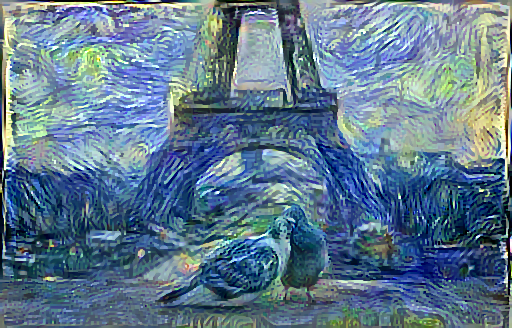

Train step: 1000
Total time: 2757.8


In [46]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

<b>Observation:</b> after adding a few more layers to both content and style, we can see that it takes longer to train the model, but the resulted picture captures the style even better.

### Progress Log 5

At this point, I used the same realistic image for both content and style, and ran the model obtained from the previous checkpoint on the updated data images.

In [47]:
content_image = load_img(content_path)
style_image = load_img(content_path)

In [48]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 328, 512, 64)
  min:  0.0
  max:  832.3692
  mean:  27.072126

block1_conv2
  shape:  (1, 328, 512, 64)
  min:  0.0
  max:  2126.1052
  mean:  153.40936

block2_conv1
  shape:  (1, 164, 256, 128)
  min:  0.0
  max:  2917.6316
  mean:  147.56244

block2_conv2
  shape:  (1, 164, 256, 128)
  min:  0.0
  max:  7200.351
  mean:  129.9377

block3_conv1
  shape:  (1, 82, 128, 256)
  min:  0.0
  max:  9427.926
  mean:  131.49495

block3_conv2
  shape:  (1, 82, 128, 256)
  min:  0.0
  max:  9654.526
  mean:  169.65866

block4_conv1
  shape:  (1, 41, 64, 512)
  min:  0.0
  max:  13836.349
  mean:  496.98294

block4_conv2
  shape:  (1, 41, 64, 512)
  min:  0.0
  max:  16094.691
  mean:  309.90237

block5_conv1
  shape:  (1, 20, 32, 512)
  min:  0.0
  max:  2606.9402
  mean:  36.868526



In [49]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

style_results = results['style']

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.015391409
    max:  64293.316
    mean:  310.50476

   block1_conv2
    shape:  (1, 64, 64)
    min:  60.94703
    max:  385511.25
    mean:  8375.03

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  81377.35
    mean:  10615.193

   block2_conv2
    shape:  (1, 128, 128)
    min:  0.06895662
    max:  238289.39
    mean:  8134.5654

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  253920.17
    mean:  9563.589

   block3_conv2
    shape:  (1, 256, 256)
    min:  96.32713
    max:  344500.4
    mean:  15301.782

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  2516687.0
    mean:  134336.42

   block4_conv2
    shape:  (1, 512, 512)
    min:  0.0
    max:  1734061.1
    mean:  60573.305

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  67095.27
    mean:  1183.6329

Contents:
   block5_conv2
    shape:  (1, 20, 32, 512)
    min:  0.0
    max:  1044.2454
    me

In [50]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [51]:
image = tf.Variable(content_image)

In [52]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [53]:
style_weight=1e-2
content_weight=1e4

In [54]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [55]:
tf.image.total_variation(image).numpy()

array([19664.25], dtype=float32)

In [56]:
image = tf.Variable(content_image)

In [57]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

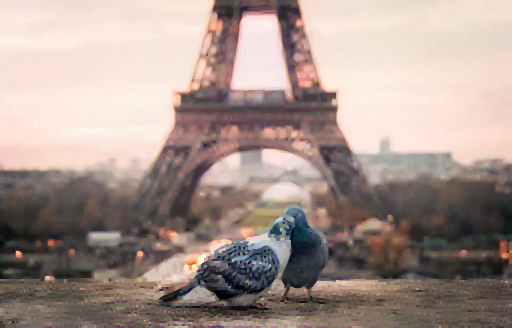

Train step: 1000
Total time: 2728.3


In [58]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

<b>Observation:</b> after using the content picture for styling itself, we can see that the picture is somewhat coverred with a layer of its own corlours, and therefore, it looks a bit blurry and more cartoon-like.

### Progress Log 6

At this point, I swapped the images of both content and style, and ran the model obtained from the fourth checkpoint on the updated data images. I also did a bit of research on GradientTape to see what it did as it was called in the train method.

In [59]:
content_image = load_img(style_path)
style_image = load_img(content_path)

In [60]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 328, 512, 64)
  min:  0.0
  max:  832.3692
  mean:  27.072126

block1_conv2
  shape:  (1, 328, 512, 64)
  min:  0.0
  max:  2126.1052
  mean:  153.40936

block2_conv1
  shape:  (1, 164, 256, 128)
  min:  0.0
  max:  2917.6316
  mean:  147.56244

block2_conv2
  shape:  (1, 164, 256, 128)
  min:  0.0
  max:  7200.351
  mean:  129.9377

block3_conv1
  shape:  (1, 82, 128, 256)
  min:  0.0
  max:  9427.926
  mean:  131.49495

block3_conv2
  shape:  (1, 82, 128, 256)
  min:  0.0
  max:  9654.526
  mean:  169.65866

block4_conv1
  shape:  (1, 41, 64, 512)
  min:  0.0
  max:  13836.349
  mean:  496.98294

block4_conv2
  shape:  (1, 41, 64, 512)
  min:  0.0
  max:  16094.691
  mean:  309.90237

block5_conv1
  shape:  (1, 20, 32, 512)
  min:  0.0
  max:  2606.9402
  mean:  36.868526



In [61]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

style_results = results['style']

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.005941177
    max:  12400.008
    mean:  1322.5427

   block1_conv2
    shape:  (1, 64, 64)
    min:  264.8366
    max:  824037.56
    mean:  23984.11

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  345129.34
    mean:  39910.285

   block2_conv2
    shape:  (1, 128, 128)
    min:  0.0
    max:  379600.03
    mean:  30847.543

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  869452.6
    mean:  32634.629

   block3_conv2
    shape:  (1, 256, 256)
    min:  3.2395842
    max:  821598.56
    mean:  48143.508

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  10199814.0
    mean:  362348.7

   block4_conv2
    shape:  (1, 512, 512)
    min:  0.0
    max:  4543310.5
    mean:  141106.47

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  140146.86
    mean:  2315.2822

Contents:
   block5_conv2
    shape:  (1, 25, 32, 512)
    min:  0.0
    max:  1688.0007
    mean

In [62]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [63]:
image = tf.Variable(content_image)

In [64]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [65]:
style_weight=1e-2
content_weight=1e4

In [66]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [67]:
tf.image.total_variation(image).numpy()

array([97676.79], dtype=float32)

In [68]:
image = tf.Variable(content_image)

In [69]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

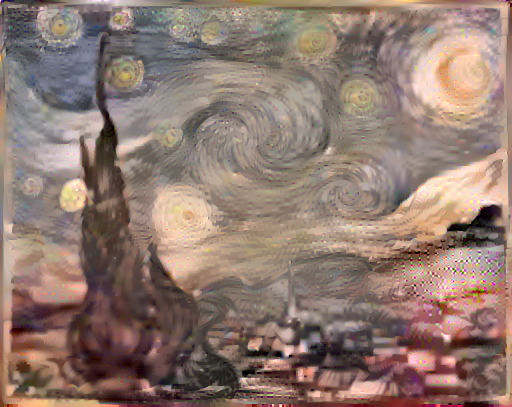

Train step: 1000
Total time: 3367.8


In [70]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

<b>Observation:</b> the Starry Night painting is now re-painted with the corlours from the realistic image. Specifically, like the previous checkpoint, the picture is coverred with a layer of those corlours.

## Progress Log

1. I ran into a few issues loading images from a directory to the notebook which was a pretty dumb moment of mine but then I figured it out by having a more careful look at the tutorial and a bit of google search. I created a folder named "data" containing the two images and defined the path (for example, /data/content.jpg) in the notebook and it worked just fine. I believe having a sub-folder containing the images makes my working directory look neat and nice.

2. Before training the model, I decided to test the pictures on TF-hub's Fast Style Transfer (FST) to get some first ideas about what to expect after training the models on the pictures. For the original case, FST did not do a very good job on reproducing the content image with Van Gogh's style used on the Starry Night; I felt like it was not even half-way close and I didn't really know the reason why. Maybe FST did not go through a lot of training epochs before releasing the result. For the second case where I used the same realistic image for both content and style, the pigeons picture looked more cartoon-like; specifically, like it was coverred with a layer of its own colours. Similary for the third case where I swapped the pictures, the Starry Night painting was coverred with a layer of the realistic picture's corlours, broadly speaking. These results gave me a heads-up on what I should expect to see for the following steps.

3. I used the same model suggested in the tutorial (link attached at the beginning of the notebook) and trained the model with my images (the pigeons and Starry Night). Both the regular implementation and the enhanced implementation (i.e. the one utilising the total variation loss) produced a much better picture than the one given by TF-hub FTS, as expected. During the process, the style was calculated by using the equation giving in the tutorial. The equation seemed a bit complicated and pretty hard to implement from scratch but with the help of einsum() given by tf.linalg, we could actually input the equation with just one line, like that the tutorial did. This function returns a tensor whose elements are defined by equation, which is written in a shorthand form inspired by the Einstein summation convention. For example, C[i,k] = sum_j A[i,j] * B[j,k] and be re-written as ij,jk->ik. Apply this fact to the equation given in the tutorial, we can see that this part, ('bijc,bijd->bcd', input_tensor, input_tensor), makes more sense if we look at the subscripts of the equations, that is, 'bcd' is the result given by 'bijc' and 'bijd' as can be seen from the numerator on the RHS of the equation. I don't want to claim that I fully understand einsum() but at least I have some ideas about what was going on. I referenced from: https://www.tensorflow.org/api_docs/python/tf/einsum 

4. I repeated the step on the previous checkpoint but added more layers to the content and style to see if it had any changes. I bet there must be some kind of rules about what to choose for the layers but I just wanted to try something out. Specifically, the following are the updated layers:
    
    content_layers = ['block5_conv2', 'block5_conv3', 'block5_conv4'] 

    style_layers = ['block1_conv1', 'block1_conv2', 'block2_conv1', 'block2_conv2', 'block3_conv1', 'block3_conv2', 'block4_conv1', 'block4_conv2', 'block5_conv1']

    The results show that it took longer to finish the training but the resulted picture looked better than the previous ones, in my opinion. Maybe it did a better job on optimising. Still, I did not know for sure how the tutorial knew that to choose for the layers. 

5. Again, I repeated what I did in the previous checkpoint, but this time I used the same realistic image for both content and style. As we can see from the result, the pigeons picture got blurry like it was coverred by a layer of its own colours. In my opinion, as there is no styling in any realistic pictures, the model could only capture the colours in those imgages and then put spread the corlours on the content images that it is given. In other words, each artist's style is, obviously, unique and unreal; it's the artist's signature, and that's what the model was looking for. Realistic images have no such thing, they are kind of general, and therefore, the model can only study the corlours.

6. And again, I repeated the steps I made in the fourth and fifth checkpoint, but this time I swapped the images, content for style, and style for content. As expected, the Starry Night was coverred with the colour layer getting from the pigeons photo and interestingly, this case happened to be the longest one to train in terms of time. I acknowledged that repeating code over and over again was not a vey good idea and I did try to make some method for training so that I didn't have to repeat, but sadly, it was not working properly so I decided to go back to the naive way and removed the blocks containing the methods I made. Regarding my research on GradientTape, I had some reference in the following link: https://www.tensorflow.org/api_docs/python/tf/GradientTape

    I could not understand all of the magic behind it, but broadly speaking, this tape somehow monitors the gradients as the training goes and from that it keeps updating the gradietns thus giving us gradient descent. 